In [1]:
!pip install rasterio pandas openpyxl geopandas matplotlib
!pip install gdown
!pip install Pillow
!pip install tqdm

import rasterio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.enums import Resampling
from rasterio.warp import transform


import json
import pprint
import gdown
import csv
import re


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 18.5 MB/s eta 0:00:00


In [2]:

file_id = "1QMUGMu-kQNyHPttE9u9lM_WGCnA6xtBS"
url = f"https://drive.google.com/uc?id={file_id}"


output = "flood.tif"
gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1QMUGMu-kQNyHPttE9u9lM_WGCnA6xtBS
From (redirected): https://drive.google.com/uc?id=1QMUGMu-kQNyHPttE9u9lM_WGCnA6xtBS&confirm=t&uuid=acfa7eb9-f94e-4415-b8a1-2c28f1452bda
To: /content/flood.tif
100%|██████████| 4.24G/4.24G [00:50<00:00, 83.7MB/s]


'flood.tif'

taking info from google map

In [3]:
file_id = "1AG2r7Jlj1sqt9jg0fro8bEMTDUyE6O9u"
url = f"https://drive.google.com/uc?id={file_id}"


output = "locations.json"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1AG2r7Jlj1sqt9jg0fro8bEMTDUyE6O9u
To: /content/locations.json
100%|██████████| 23.5k/23.5k [00:00<00:00, 44.4MB/s]


'locations.json'

In [4]:
# Load the JSON file
def load_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

#  print the contents of the JSON file
def show_json_contents(file_path):
    data = load_json_file(file_path)
    pprint.pprint(data)  # Pretty print the JSON content for better readability

# File path to your JSON file
file_path = '/content/locations.json'

# Show the contents of the file
show_json_contents(file_path)

{'features': [{'geometry': {'coordinates': [0, 0], 'type': 'Point'},
               'properties': {'Comment': 'No location information is available '
                                         'for this saved place',
                              'date': '2024-10-16T19:45:55Z',
                              'google_maps_url': 'http://maps.google.com/?q=45.4243635,-75.68212989999999'},
               'type': 'Feature'},
              {'geometry': {'coordinates': [0, 0], 'type': 'Point'},
               'properties': {'Comment': 'No location information is available '
                                         'for this saved place',
                              'date': '2024-10-16T19:45:52Z',
                              'google_maps_url': 'http://maps.google.com/?q=45.424588,-75.6823163'},
               'type': 'Feature'},
              {'geometry': {'coordinates': [0, 0], 'type': 'Point'},
               'properties': {'Comment': 'No location information is available '
                

In [5]:
# Load the JSON file
def load_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

#  count the number of locations in the JSON file
def count_locations(data):
    location_count = 0

    # Check if the data is a dictionary or list
    if isinstance(data, dict):
        for key, value in data.items():

            if isinstance(value, list):
                location_count += len(value)
            elif isinstance(value, dict):
                location_count += count_locations(value)
    elif isinstance(data, list):
        location_count += len(data)

    return location_count


file_path = '/content/locations.json'

json_data = load_json_file(file_path)

location_count = count_locations(json_data)

# Print the number of locations
print(f"Number of locations in the file: {location_count}")


Number of locations in the file: 61


In [6]:
# Load and inspect the JSON file
file_path = '/content/locations.json'
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(json.dumps(data, indent=4))


{
    "type": "FeatureCollection",
    "features": [
        {
            "geometry": {
                "coordinates": [
                    0,
                    0
                ],
                "type": "Point"
            },
            "properties": {
                "date": "2024-10-16T19:45:55Z",
                "google_maps_url": "http://maps.google.com/?q=45.4243635,-75.68212989999999",
                "Comment": "No location information is available for this saved place"
            },
            "type": "Feature"
        },
        {
            "geometry": {
                "coordinates": [
                    0,
                    0
                ],
                "type": "Point"
            },
            "properties": {
                "date": "2024-10-16T19:45:52Z",
                "google_maps_url": "http://maps.google.com/?q=45.424588,-75.6823163",
                "Comment": "No location information is available for this saved place"
            },
          

In [7]:

# extract latitude and longitude from the google_maps_url
def extract_coordinates_from_url(url):
    # extract latitude and longitude from the URL
    match = re.search(r'(-?\d+\.\d+),(-?\d+\.\d+)', url)
    if match:
        latitude = float(match.group(1))
        longitude = float(match.group(2))
        return latitude, longitude
    return None, None

# extract transformer locations
def extract_transformer_locations(data):
    transformers = []

    # Counter for sequential naming of transformers
    counter = 1

    for feature in data.get("features", []):
        properties = feature.get("properties", {})
        google_maps_url = properties.get("google_maps_url")

        if google_maps_url:
            latitude, longitude = extract_coordinates_from_url(google_maps_url)
            if latitude and longitude:

                transformer_name = f"tran{counter}"
                transformers.append({
                    'name': transformer_name,
                    'latitude': latitude,
                    'longitude': longitude
                })
                counter += 1

    return transformers

# Load the JSON file
file_path = '/content/locations.json'
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract the transformer locations
transformer_locations = extract_transformer_locations(data)

# Check if any transformers were found
if not transformer_locations:
    print("No valid transformer locations found.")
else:
    # Save to CSV
    output_file = '/content/transformers_coordinates.csv'
    with open(output_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=['name', 'latitude', 'longitude'])
        writer.writeheader()
        for transformer in transformer_locations:
            writer.writerow(transformer)

    print(f"Transformer locations have been saved to {output_file}.")


Transformer locations have been saved to /content/transformers_coordinates.csv.


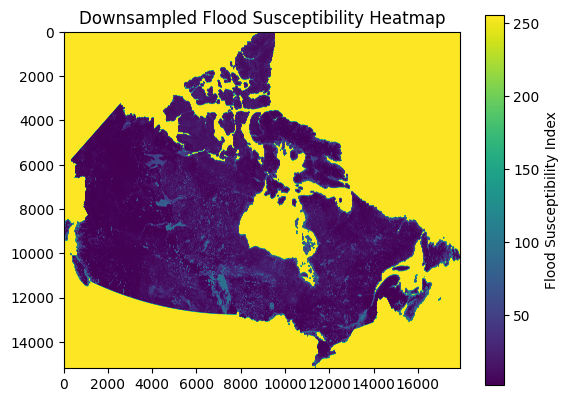

In [8]:

# Path to your TIF file
tif_path = '/content/flood.tif'

# Open the TIF file
with rasterio.open(tif_path) as dataset:
    # reduce resolution for memory efficiency
    scale_factor = 10  # downsample

    # Calculate the new dimensions
    new_height = int(dataset.height // scale_factor)
    new_width = int(dataset.width // scale_factor)

    # Read the data using the downsampled dimensions (Resampling.nearest for basic downsampling)
    data = dataset.read(
        1,
        out_shape=(new_height, new_width),
        resampling=Resampling.nearest
    )

    # Calculate the new affine transform
    new_transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

    # Plot the downsampled data
    plt.imshow(data, cmap='viridis')
    plt.colorbar(label='Flood Susceptibility Index')
    plt.title('Downsampled Flood Susceptibility Heatmap')
    plt.show()


Dataset CRS: EPSG:3979


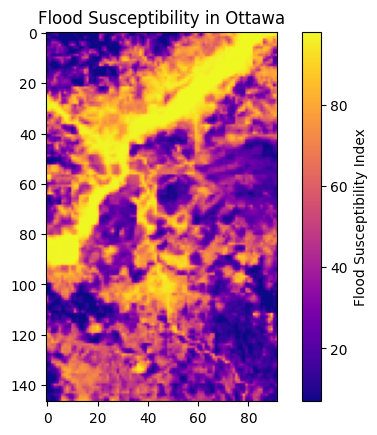

In [9]:

# Latitude and longitude boundaries for Ottawa
min_lat, max_lat = 45.22, 45.52
min_lon, max_lon = -75.92, -75.42

# Open the TIF file
with rasterio.open(tif_path) as dataset:
    # Get the CRS of the dataset
    dataset_crs = dataset.crs
    print(f"Dataset CRS: {dataset_crs}")

    # Convert latitude/longitude to the dataset's CRS
    # This assumes your input lat/lon is in EPSG:4326 (WGS84)
    lon_lat_bounds = [[min_lon, max_lon], [min_lat, max_lat]]  # Longitudes first
    transformed_bounds = transform('EPSG:4326', dataset.crs, lon_lat_bounds[0], lon_lat_bounds[1])

    # Get the row and column indices of the transformed bounds in the dataset's CRS
    min_row, min_col = dataset.index(transformed_bounds[0][0], transformed_bounds[1][1])  # Upper left corner
    max_row, max_col = dataset.index(transformed_bounds[0][1], transformed_bounds[1][0])  # Lower right corner

    # Create a window around Ottawa
    window = rasterio.windows.Window.from_slices((min_row, max_row), (min_col, max_col))

    # Downsample the data to reduce memory usage
    scale_factor = 10
    new_height = (max_row - min_row) // scale_factor
    new_width = (max_col - min_col) // scale_factor

    # Read the cropped and downsampled data
    data = dataset.read(1, window=window, out_shape=(new_height, new_width), resampling=Resampling.nearest)

    # Check if the data is valid
    if data.size == 0:
        raise ValueError("No data found in the selected window. Check your lat/lon bounds.")

    # Normalize the data to improve visibility (optional, adjust to your data range)
    data = np.clip(data, np.percentile(data, 2), np.percentile(data, 98))  # Clip extremes for better contrast

    # Plot the cropped and normalized data with a brighter colormap
    plt.imshow(data, cmap='plasma', vmin=data.min(), vmax=data.max())
    plt.colorbar(label='Flood Susceptibility Index')
    plt.title('Flood Susceptibility in Ottawa')
    plt.show()


In [10]:

# Path to your TIF file and CSV file
csv_path = '/content/transformers_coordinates.csv'

# Open the CSV file containing transformer coordinates
transformer_data = pd.read_csv(csv_path)

# Open the TIF file
with rasterio.open(tif_path) as dataset:
    # Get the CRS of the dataset
    dataset_crs = dataset.crs
    print(f"Dataset CRS: {dataset_crs}")

    # Initialize a list to store index values
    index_values = []

    # Read each transformer's coordinates and extract the index value
    for index, row in transformer_data.iterrows():
        lon = row['longitude']
        lat = row['latitude']

        # Transform coordinates to the dataset's CRS
        transformer_x, transformer_y = transform('EPSG:4326', dataset_crs.to_string(), [lon], [lat])

        # Get the pixel indices
        row_index, col_index = dataset.index(transformer_x[0], transformer_y[0])

        # Read a small area around the transformer to reduce memory usage
        window = dataset.read(1, window=rasterio.windows.Window(col_index - 1, row_index - 1, 3, 3))

        # Extract the value from the window (center pixel value)
        if window.shape[0] > 0 and window.shape[1] > 0:
            index_value = window[1, 1]  # Middle pixel value
            index_values.append(index_value)
        else:
            index_values.append(None)  # If the location is out of bounds, append None

# Add the index values to the DataFrame
transformer_data['Flood Susceptibility Index'] = index_values

# Save the updated DataFrame to a new CSV file without modifying the original index values
output_csv_path = '/content/transformers_with_index.csv'
transformer_data.to_csv(output_csv_path, index=False)

print(f"New CSV file with Flood Susceptibility Index has been created at: {output_csv_path}")


Dataset CRS: EPSG:3979
New CSV file with Flood Susceptibility Index has been created at: /content/transformers_with_index.csv
